In [1]:
import json
import pandas as pd

读取数据。由于数据量巨大，所以只读取前50000条数据

In [2]:
data = []

with open('../data/otto-recsys-train.jsonl', 'r') as f:
    for i, line in enumerate(f):
        if i >= 50000:   # 只读前5万行
            break
        data.append(json.loads(line))

print("读取的 session 数量：", len(data))
print("第一条数据结构：")
print(data[0])

读取的 session 数量： 50000
第一条数据结构：
{'session': 0, 'events': [{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'}, {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'}, {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}, {'aid': 16246, 'ts': 1659367719997, 'type': 'clicks'}, {'aid': 1781822, 'ts': 1659367871344, 'type': 'clicks'}, {'aid': 1152674, 'ts': 1659367885796, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659369893840, 'type': 'carts'}, {'aid': 461689, 'ts': 1659369898050, 'type': 'carts'}, {'aid': 305831, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 461689, 'ts': 1659370027105, 'type': 'orders'}, {'aid': 362233, 'ts': 1659370064916, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659370067686, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371003682, 'type': 'clicks'}, {'aid': 984597, 'ts': 1659371033243, 'type': 'clicks'}, {'aid': 1649869, 'ts': 1659371042297, 'type': 'clicks'}, {'aid': 803544, 'ts': 1659371044075, 'type': 'clicks'}, {'aid': 1110941, 'ts': 1659371104329, 'ty

In [3]:
rows = []

for session in data:
    session_id = session['session']
    for event in session['events']:
        rows.append({
            "session": session_id,
            "aid": event['aid'],
            "ts": event['ts'],
            "type": event['type']
        })

event_df = pd.DataFrame(rows)

print("事件总数：", len(event_df))
event_df.head()

事件总数： 2621110


,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks


50000个session中共有2621110条event。

In [4]:
event_df['type'].value_counts()#event情况分布

type
clicks    2395745
carts      180595
orders      44770
Name: count, dtype: int64

In [5]:
session_stats = event_df.groupby('session')['type'].count()

print("平均每个 session 行为数:", session_stats.mean())
print("中位数:", session_stats.median())
print("最大值:", session_stats.max())

平均每个 session 行为数: 52.4222
中位数: 19.0
最大值: 495


In [6]:
session_conversion = event_df.groupby('session')['type'].apply(
    lambda x: 'orders' in x.values
)

conversion_rate = session_conversion.mean()

print("Session 转化率:", conversion_rate)

Session 转化率: 0.22962


下面进行用户特征工程。对每个session的情况进行分析，构建session级数据。

In [7]:
session_features = event_df.groupby('session').agg(
    total_events = ('type', 'count'),
    click_cnt = ('type', lambda x: (x == 'clicks').sum()),
    cart_cnt = ('type', lambda x: (x == 'carts').sum()),
    order_cnt = ('type', lambda x: (x == 'orders').sum())
)

session_features['converted'] = session_features['order_cnt'] > 0

session_features.head()

,total_events,click_cnt,cart_cnt,order_cnt,converted
session,,,,,
0,276,255,17,4,True
1,32,24,8,0,False
2,33,32,1,0,False
3,226,200,21,5,True
4,19,15,3,1,True


比较转化用户和未转化用户。

In [8]:
session_features.groupby('converted').mean()


,total_events,click_cnt,cart_cnt,order_cnt
converted,,,,
False,31.791713,30.346245,1.445468,0.000000
True,121.637924,106.858113,10.880324,3.899486


寻找高价值用户。

In [9]:
median_events = session_features['total_events'].median()

high_value = session_features[
    (session_features['total_events'] > median_events) &
    (session_features['converted'] == True)
]

len(high_value)

10282

转化用户VS未转化用户行为差异。

In [10]:
conversion_summary = session_features.groupby('converted').agg(
    avg_click=('click_cnt', 'mean'),
    avg_cart=('cart_cnt', 'mean'),
    avg_events=('total_events', 'mean')
)

conversion_summary

,avg_click,avg_cart,avg_events
converted,,,
False,30.346245,1.445468,31.791713
True,106.858113,10.880324,121.637924


很明显转化用户平均点击率，平均购买意愿，平均购买行为都明显高于未转化用户。接下来计算加购行为占比。

In [11]:
conversion_summary['cart_ratio'] = (
    conversion_summary['avg_cart'] /
    conversion_summary['avg_events']
)

conversion_summary

,avg_click,avg_cart,avg_events,cart_ratio
converted,,,,
False,30.346245,1.445468,31.791713,0.045467
True,106.858113,10.880324,121.637924,0.089448


转化用户cart_ratio明显更高，说明行为结构比行为数量要更为重要。

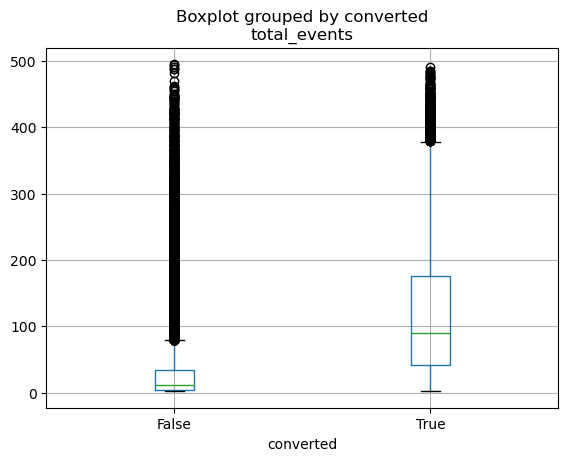

In [12]:
import matplotlib.pyplot as plt

session_features.boxplot(column='total_events', by='converted')
plt.show()

寻找超高价值用户。

In [13]:
threshold = session_features['total_events'].quantile(0.75)

super_users = session_features[
    (session_features['total_events'] > threshold) &
    (session_features['converted'] == True)
]

len(super_users)

7196

In [14]:
session_features.corr()

,total_events,click_cnt,cart_cnt,order_cnt,converted
total_events,1.000000,0.994433,0.680712,0.491501,0.486636
click_cnt,0.994433,1.000000,0.602871,0.426384,0.453109
cart_cnt,0.680712,0.602871,1.000000,0.618487,0.474275
order_cnt,0.491501,0.426384,0.618487,1.000000,0.605349
converted,0.486636,0.453109,0.474275,0.605349,1.000000


通过构建 Session 级别特征并进行相关性分析，发现加购行为（cart_cnt）对转化具有更高预测能力，显著高于点击行为；同时用户整体活跃度（total_events）也与转化呈中度正相关。

In [15]:
session_features.groupby('converted').mean()

,total_events,click_cnt,cart_cnt,order_cnt
converted,,,,
False,31.791713,30.346245,1.445468,0.000000
True,121.637924,106.858113,10.880324,3.899486


转化用户的行为量是未转化用户的近4倍，说明用户活跃度与转化高度相关。

In [16]:
session_features['click_ratio'] = session_features['click_cnt'] / session_features['total_events']
session_features['cart_ratio'] = session_features['cart_cnt'] / session_features['total_events']

session_features.groupby('converted')[['click_ratio','cart_ratio']].mean()

,click_ratio,cart_ratio
converted,,
False,0.966389,0.033611
True,0.845002,0.102090


由此可见，决定转化的不是“点击多”，而是“加购占比多”。

准备数据，构建Logistics Regression。

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X = session_features[['click_cnt','cart_cnt']]
y = session_features['converted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)

print("AUC:", auc)

AUC: 0.8950338841696261


In [23]:
coef_df = pd.DataFrame({
    "feature": ['click_cnt','cart_cnt'],
    "coef": model.named_steps['logisticregression'].coef_[0]
})

coef_df

,feature,coef
0,click_cnt,0.439754
1,cart_cnt,1.445519


在控制点击行为的情况下，加购行为对转化概率的边际提升显著高于点击行为，说明高意图行为是转化的核心驱动因素。

接下来进行 A/B Test。首先进行随机分组（模拟线上流量切分）。

In [24]:
import numpy as np

np.random.seed(42)

session_features['group'] = np.random.choice(
    ['control','treatment'],
    size=len(session_features)
)

session_features['group'].value_counts()

group
control      25046
treatment    24954
Name: count, dtype: int64

假设：新算法对高 cart 用户提升 20% 转化概率。人为制造 uplift。

In [25]:
session_features['new_converted'] = session_features['converted'].copy()

high_cart_threshold = session_features['cart_cnt'].quantile(0.75)

mask = (
    (session_features['group'] == 'treatment') &
    (session_features['cart_cnt'] > high_cart_threshold)
)

# 给 treatment 高意图用户增加转化
session_features.loc[mask, 'new_converted'] = True

计算两组转化率。

In [26]:
ab_result = session_features.groupby('group')['new_converted'].mean()
ab_result

group
control      0.228220
treatment    0.316021
Name: new_converted, dtype: float64

显著性检验。

In [27]:
from statsmodels.stats.proportion import proportions_ztest

control = session_features[session_features['group']=='control']
treatment = session_features[session_features['group']=='treatment']

count = [
    treatment['new_converted'].sum(),
    control['new_converted'].sum()
]

nobs = [
    len(treatment),
    len(control)
]

stat, pval = proportions_ztest(count, nobs)

print("Z-stat:", stat)
print("p-value:", pval)

Z-stat: 22.058988433056772
p-value: 7.831456913511434e-108


p-value < 0.05，差异显著。

计算uplift和CI。

In [28]:
import statsmodels.api as sm

# 两组转化率
p1 = treatment['new_converted'].mean()
p2 = control['new_converted'].mean()

uplift = p1 - p2

# 计算标准误
se = np.sqrt(
    p1*(1-p1)/len(treatment) +
    p2*(1-p2)/len(control)
)

# 95% CI
ci_lower = uplift - 1.96*se
ci_upper = uplift + 1.96*se

print("Uplift:", uplift)
print("95% CI:", ci_lower, ci_upper)

Uplift: 0.08780140446043494
95% CI: 0.08003661234957973 0.09556619657129015


功效分析。

In [29]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# baseline
p1 = 0.22

# 提升到
p2 = 0.24

# 计算 effect size
effect_size = proportion_effectsize(p2, p1)

analysis = NormalIndPower()

sample_size = analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

print("每组需要样本量:", int(sample_size))

每组需要样本量: 6947


In [30]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# baseline
p1 = 0.22

# 提升到
p2 = 0.23

# 计算 effect size
effect_size = proportion_effectsize(p2, p1)

analysis = NormalIndPower()

sample_size = analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

print("每组需要样本量:", int(sample_size))

每组需要样本量: 27369
